In [2]:
pip install --upgrade tensorflow import os

  Using cached tensorflow-2.13.0-cp39-cp39-win_amd64.whl (1.9 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement import (from versions: none)
ERROR: No matching distribution found for import


In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install librosa soundfile

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import soundfile as sf
from scipy import interpolate
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from itertools import cycle


# Model Building

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


train_dir = 'C:/Users/Lakshmi/Desktop/Main project/augmented_audio/train'


def load_data(data_dir, max_length):
    data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for audio_file in os.listdir(class_dir):
            if audio_file.endswith('.ogg'):
                audio_path = os.path.join(class_dir, audio_file)
                audio, _ = librosa.load(audio_path, sr=None)
                if len(audio) < max_length:
                    padding = np.zeros(max_length - len(audio))
                    audio = np.concatenate((audio, padding))
                else:
                    audio = audio[:max_length]
                data.append(audio)
                labels.append(class_idx)
    
    return np.array(data), np.array(labels)


sampling_rate = 44100 
time_in_seconds = 0.3  #Maximum duration in seconds
max_length = int(time_in_seconds * sampling_rate)

# Loading training data
train_data, train_labels = load_data(train_dir, max_length)


num_classes = 7


train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)

# Build the model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(max_length, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model using only the training data (without validation)
history = model.fit(train_data.reshape(-1, max_length, 1), train_labels, epochs=15, batch_size=32, validation_split=0)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13228, 16)         64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 6614, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 6612, 32)          1568      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3306, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 3304, 64)          6208      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1652, 64)          0

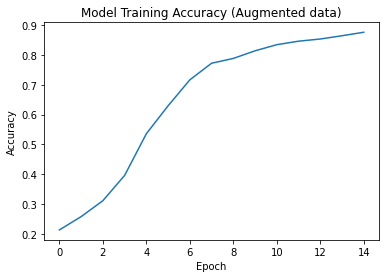

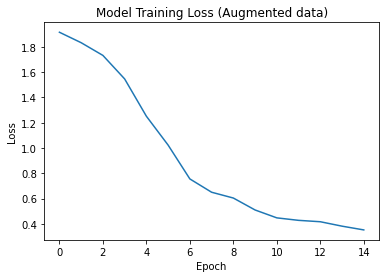

In [19]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy (Augmented data)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss (Augmented data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


## Evaluating the Model Using test data

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

test_dir = 'C:/Users/Lakshmi/Desktop/Main project/spectral_reduced_audio/test'

# Load testing data
test_data, test_labels = load_data(test_dir, max_length)

# Predict using the trained model
test_predictions = model.predict(test_data.reshape(-1, max_length, 1))
test_predictions_labels = np.argmax(test_predictions, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_labels, test_predictions_labels)
print("Classification Report:")
print(class_report)


23/23 [==============================] - 3s 104ms/step
Test Accuracy: 0.25
Confusion Matrix:
[[ 6 12  6 18 31  4 35]
 [ 2  9  3 24 15  5 20]
 [ 2  5 23  7 27  3 19]
 [ 4  4  2 20  7  1 24]
 [10  2 11 22 35 13 35]
 [10  2 11 17 32 28 34]
 [ 3  1  7 24 22  8 57]]
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.05      0.08       112
           1       0.26      0.12      0.16        78
           2       0.37      0.27      0.31        86
           3       0.15      0.32      0.21        62
           4       0.21      0.27      0.24       128
           5       0.45      0.21      0.29       134
           6       0.25      0.47      0.33       122

    accuracy                           0.25       722
   macro avg       0.26      0.24      0.23       722
weighted avg       0.27      0.25      0.23       722



In [15]:
# Load and preprocess the unseen audio file
new_audio, _ = librosa.load('audio_dataset/train/day_2/WhatsApp Audio 2023-07-06 at 7.35.47 PM.ogg', sr=None)
if len(new_audio) < max_length:
    padding = np.zeros(max_length - len(new_audio))
    new_audio = np.concatenate((new_audio, padding))
else:
    new_audio = new_audio[:max_length]

# Reshape and normalize the data
new_audio = new_audio.reshape(1, max_length, 1)

# Make predictions
predictions = model.predict(new_audio)
predicted_day = np.argmax(predictions)

# Convert the predicted class index to the corresponding day
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
predicted_day_name = days_of_week[predicted_day]

print(f'Predicted day: {predicted_day_name}')

1/1 [==============================] - 0s 44ms/step
Predicted day: Monday


##  training with normalised data

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


train_dir = 'C:/Users/Lakshmi/Desktop/Main project/normalized_augmented_audio/train'


def load_data(data_dir, max_length):
    data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for audio_file in os.listdir(class_dir):
            if audio_file.endswith('.ogg'):
                audio_path = os.path.join(class_dir, audio_file)
                audio, _ = librosa.load(audio_path, sr=None)
                if len(audio) < max_length:
                    padding = np.zeros(max_length - len(audio))
                    audio = np.concatenate((audio, padding))
                else:
                    audio = audio[:max_length]
                data.append(audio)
                labels.append(class_idx)
    
    return np.array(data), np.array(labels)


sampling_rate = 44100 
time_in_seconds = 0.3  #Maximum duration in seconds
max_length = int(time_in_seconds * sampling_rate)

# Loading training data
train_data, train_labels = load_data(train_dir, max_length)


num_classes = 7


train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)

# Build the model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(max_length, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model using only the training data (without validation)
history = model.fit(train_data.reshape(-1, max_length, 1), train_labels, epochs=15, batch_size=32, validation_split=0)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 13228, 16)         64        
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 6614, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 6612, 32)          1568      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 3306, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 3304, 64)          6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1652, 64)         

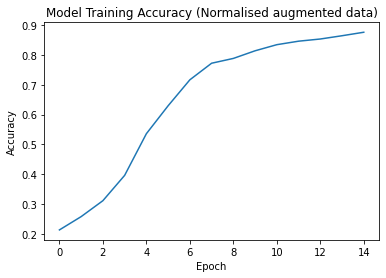

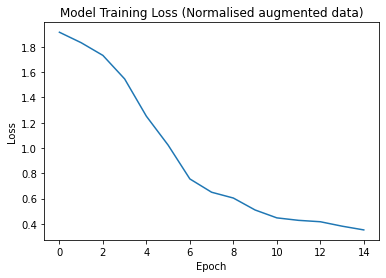

In [20]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy (Normalised augmented data)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss (Normalised augmented data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

test_dir = 'C:/Users/Lakshmi/Desktop/Main project/spectral_reduced_audio/test'

# Load testing data
test_data, test_labels = load_data(test_dir, max_length)

# Predict using the trained model
test_predictions = model.predict(test_data.reshape(-1, max_length, 1))
test_predictions_labels = np.argmax(test_predictions, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_labels, test_predictions_labels)
print("Classification Report:")
print(class_report)

23/23 [==============================] - 2s 96ms/step
Test Accuracy: 0.31
Confusion Matrix:
[[24  8  9 34 15 11 11]
 [ 8  6  5 35  6  9  9]
 [24  6 23 13  9  4  7]
 [15  4  1 34  0  3  5]
 [25  4 11 28 26 24 10]
 [16  3  2 17 10 78  8]
 [31  7  4 33  8  6 33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.21      0.19       112
           1       0.16      0.08      0.10        78
           2       0.42      0.27      0.33        86
           3       0.18      0.55      0.27        62
           4       0.35      0.20      0.26       128
           5       0.58      0.58      0.58       134
           6       0.40      0.27      0.32       122

    accuracy                           0.31       722
   macro avg       0.32      0.31      0.29       722
weighted avg       0.34      0.31      0.31       722



In [18]:
# Load and preprocess the unseen audio file
new_audio, _ = librosa.load('audio_dataset/train/day_6/WhatsApp Audio 2023-07-12 at 4.07.29 PM.ogg', sr=None)
if len(new_audio) < max_length:
    padding = np.zeros(max_length - len(new_audio))
    new_audio = np.concatenate((new_audio, padding))
else:
    new_audio = new_audio[:max_length]

# Reshape and normalize the data
new_audio = new_audio.reshape(1, max_length, 1)

# Make predictions
predictions = model.predict(new_audio)
predicted_day = np.argmax(predictions)

# Convert the predicted class index to the corresponding day
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
predicted_day_name = days_of_week[predicted_day]

print(f'Predicted day: {predicted_day_name}')

1/1 [==============================] - 0s 41ms/step
Predicted day: Saturday
